# Porting Bike-Sharing project-1 to RNN


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

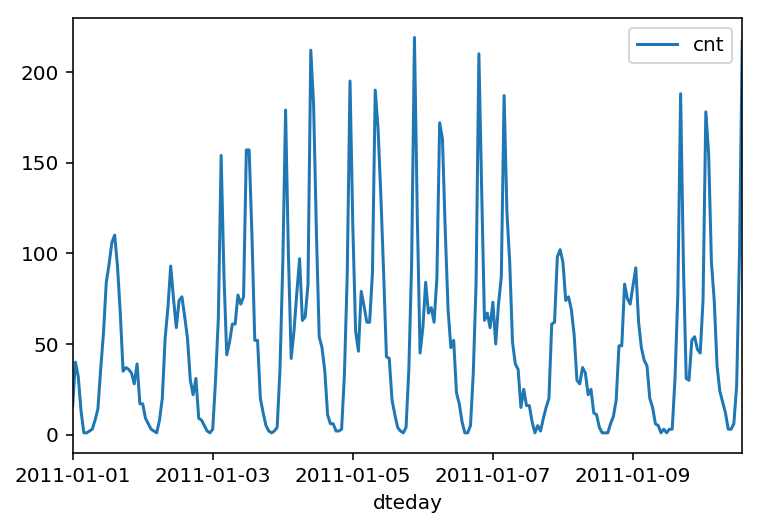

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
train_targets.head()

,cnt,casual,registered
0,-0.956312,-0.662736,-0.930162
1,-0.823998,-0.561326,-0.804632
2,-0.868103,-0.622172,-0.837666
3,-0.972851,-0.662736,-0.949983
4,-1.039008,-0.723582,-1.009445


### Lets build the get_batches 

the input of each time step will be one row of data ( one hour prediction array of 53 features) 
  

In [10]:


# each element of x is an array with 53 features and each element of y is an array with 3 targets
# each x is one hour features 
def get_batches(x, y, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       array x and array y: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of hours per batch and number of batches we can make
    hours_per_batch = n_seqs * n_steps
    n_batches = len(x)//hours_per_batch
    
    # convert from Pandas to np remove the index column
    x = x.reset_index().values[:,1:]
    y = y.reset_index().values[:,1:]

    # make only full batches    
    x, y = x[:n_batches*hours_per_batch], y[:n_batches*hours_per_batch]

    # TODO: this needs to be optmized
    # x_temp will be ( n rows x n_steps wide) where each element is an array of 53 features
    # this first look splits the x with n rows and n_steps wide 
    x_temp = []
    y_temp = []
    for st in range(0, n_batches*hours_per_batch, n_steps ):
        x_temp.append( x[st:st+n_steps]  )
        y_temp.append( y[st:st+n_steps]  )

    x = np.asarray(x_temp )    
    y = np.asarray(y_temp )    

    # this splits x in n_seqs rows so the return is a batch of n_seqs rows with n_steps wide 
    # where each element is an array of 53 features (one hour from our data)
    for sq in range(0,(n_batches*hours_per_batch)//n_steps, n_seqs ):
        yield x[sq:sq+n_seqs,:,:], y[sq:sq+n_seqs,:,:]



### Lets test the batches above

In [11]:
print(train_features.tail())
batches = get_batches(train_features, train_targets, 20, 96)
x, y = next(batches)
print(x.shape)



       yr  holiday      temp       hum  windspeed  season_1  season_2  \
15430   1        0 -0.192085  1.310171  -1.553844         0         0   
15431   1        0 -0.192085  1.310171  -0.699669         0         0   
15432   1        0 -0.192085  1.310171  -0.821460         0         0   
15433   1        0 -0.192085  1.310171  -0.821460         0         0   
15434   1        0 -0.192085  0.999178  -0.699669         0         0   

       season_3  season_4  weathersit_1    ...      hr_21  hr_22  hr_23  \
15430         0         1             0    ...          0      0      0   
15431         0         1             0    ...          0      0      0   
15432         0         1             0    ...          0      0      0   
15433         0         1             0    ...          0      0      0   
15434         0         1             1    ...          0      0      0   

       weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
15430          0          0        

In [12]:
# x, y = next(batches)
# print(x.shape)


## Build the network

Lets build a RNN with tensorflow
  
### Inputs

In [13]:
import tensorflow as tf

num_features = 56
num_targets = 3

batch_size = 10
# one step for each hour that we want the sequence to remember
num_steps = 50
lstm_size = 256
num_layers = 2
learning_rate = 0.0005
keep_prob_val = 0.75


# Declare placeholders we'll feed into the graph
inputs = tf.placeholder(tf.float32, [batch_size, None, num_features], name='inputs')
targets = tf.placeholder(tf.float32, [batch_size, None, num_targets], name='targets')

# Keep probability placeholder for drop out layers
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
learningRate = tf.placeholder(tf.float32, name='learningRate')

### Lstm

In [14]:

# # Use a basic LSTM cell
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

# # Add dropout to the cell
# drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

# # Stack up multiple LSTM layers, for deep learning
# #cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)

# initial_state = cell.zero_state(batch_size, tf.float32)

#Replaced the code above because TF with GPU was complaining 

def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    return tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_layers)], state_is_tuple = True)

initial_state = cell.zero_state(batch_size, tf.float32)

### Output

In [15]:
outputs, final_state = tf.nn.dynamic_rnn(cell, inputs,  dtype=tf.float32)

# this is one thing that I still dont fully understood, I had to set the activation_fn=None so the 
# fully connected layer dont use any activation funcition, this seems to work
predictions = tf.contrib.layers.fully_connected(outputs, 3, activation_fn=None)
cost = tf.losses.mean_squared_error(targets, predictions)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Validation Accuracy


In [16]:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(targets), tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


### Trainning

In [ ]:
epochs = 100

saver = tf.train.Saver()
#validation accuracy to plot
val_accuracy=[]
training_loss=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_features, train_targets, batch_size, num_steps), 1):

            feed = {inputs: x,
                    targets: y,
                    keep_prob: keep_prob_val,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)

            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
                training_loss.append(loss)

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_features, val_targets, batch_size, num_steps):
                    feed = {inputs: x,
                            targets: y,
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                val_accuracy.append( np.mean(val_acc) )    
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/bike-sharing.ckpt")

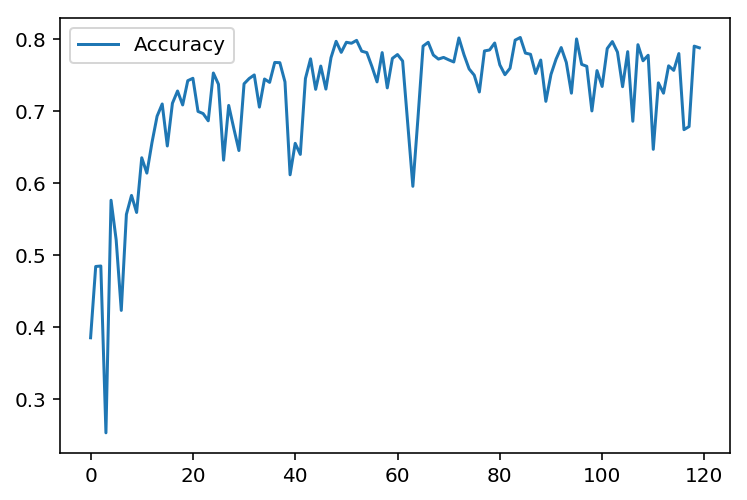

In [18]:
plt.plot(val_accuracy, label='Accuracy')
plt.legend()
_ = plt.ylim()

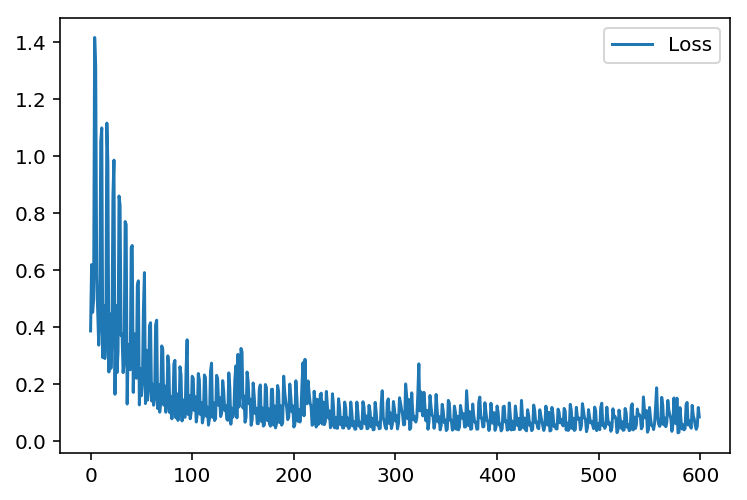

In [19]:
plt.plot(training_loss, label='Loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [20]:
test_acc = []
#with tf.Session(graph=graph) as sess:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_features, test_targets, batch_size, num_steps), 1):
        feed = {inputs: x,
                targets: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))
    

Test accuracy: 0.727


### Create a graph to compare the data and predictions

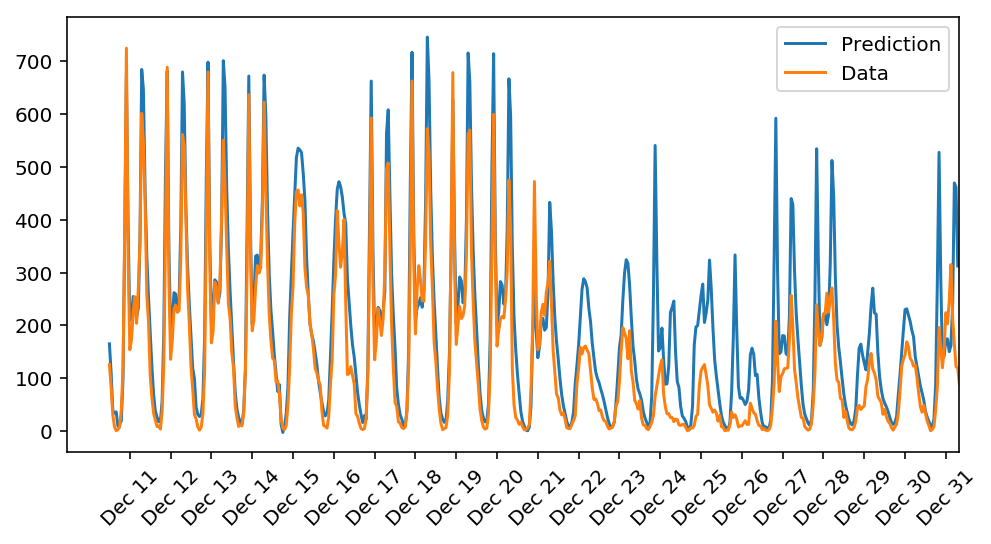

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    fig, ax = plt.subplots(figsize=(8,4))

    mean, std = scaled_features['cnt']
    batch = get_batches(test_features, test_targets, batch_size, num_steps)
    x,y = next(batch)
    feed = {inputs: x,
                targets: y,
                keep_prob: 1,
                initial_state: test_state}
    pred = sess.run([predictions], feed_dict=feed)
    pred = pred[0].reshape(500,-1)
    pred[:,0] *= std
    pred[:,0] += mean
    lf = pred[:,0]

    
    # predictions = network.run(test_features).T*std + mean
    ax.plot(lf, label='Prediction')
    ax.plot((test_targets['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(lf))
    ax.legend()

    dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

### Below is the graph of the results on the project 1 with a NN (not recurrent)

Seens that with less training the network is predicting better specially ont the Dec 29 / Dec 30 where the curve is very close compared to the project 1 NN

<img src="bike-sharing-nn-results.png" width="495" style="float:left">